# Import Library and Dataset

In [ ]:
#Load Library
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tabulate import tabulate

In [ ]:
#Load Dataset
from google.colab import files
uploaded = files.upload()

# Processing Data

In [ ]:
#Import Data
data = pd.read_csv("Bali 2015 - 2022.csv", delimiter=',')
data.head(10)

,datetime,total_visitor,total_accomodation
0,1/1/2014,279257,16495
1,2/1/2014,275795,17221
2,3/1/2014,276573,17330
3,4/1/2014,280096,17737
4,5/1/2014,286033,18836
5,6/1/2014,330396,19085
6,7/1/2014,361066,19566
7,8/1/2014,336763,19933
8,9/1/2014,354762,19566
9,10/1/2014,341651,19933


In [ ]:
train_datetime = data['datetime']
print(train_datetime)

0       1/1/2014
1       2/1/2014
2       3/1/2014
3       4/1/2014
4       5/1/2014
         ...    
103     8/1/2022
104     9/1/2022
105    10/1/2022
106    11/1/2022
107    12/1/2022
Name: datetime, Length: 108, dtype: object


In [ ]:
input_col = list(data)[1:3]
print(input_col)

['total_visitor', 'total_accomodation']


In [ ]:
data_for_training = data[input_col]

In [ ]:
data_for_training.isna().sum()

total_visitor         0
total_accomodation    0
dtype: int64

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_for_training)

In [ ]:
# Assuming 'original' contains the original data with 'Datetime' and 'total_visitor' columns
original = data[['datetime', 'total_visitor']]
original['datetime'] = pd.to_datetime(original['datetime'])
original = original.loc[original['datetime'] >= '2013-01-01']

<ipython-input-10-6b11e8758d41>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime'] = pd.to_datetime(original['datetime'])


# Scenario 1 - 80% Train - 20% Test

In [ ]:
# Define sequence length and features
sequence_length = 12  # Number of time steps in each sequence
num_features = len(data_for_training.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][1]  # '_tempm' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (76, 12, 2)
Train Y shape: (76,)
Test X shape: (20, 12, 2)
Test Y shape: (20,)


In [ ]:
# Create the GRU model
model = Sequential()

# Add GRU layers with dropout
model.add(GRU(units=256, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=64, return_sequences=False))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 256)           199680    
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 12, 128)           148224    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 385217 (1.47 MB)
Trainable params: 385217 

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=50,
    batch_size=12,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 [==============================] - 7s 421ms/step - loss: 0.0702 - val_loss: 0.1318
Epoch 2/50
5/5 [==============================] - 0s 97ms/step - loss: 0.0210 - val_loss: 0.1708
Epoch 3/50
5/5 [==============================] - 0s 99ms/step - loss: 0.0082 - val_loss: 0.0567
Epoch 4/50
5/5 [==============================] - 0s 91ms/step - loss: 0.0081 - val_loss: 0.0610
Epoch 5/50
5/5 [==============================] - 0s 86ms/step - loss: 0.0030 - val_loss: 0.0643
Epoch 6/50
5/5 [==============================] - 0s 98ms/step - loss: 0.0032 - val_loss: 0.0170
Epoch 7/50
5/5 [==============================] - 0s 103ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 8/50
5/5 [==============================] - 0s 91ms/step - loss: 9.0928e-04 - val_loss: 0.0055
Epoch 9/50
5/5 [==============================] - 0s 91ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/50
5/5 [==============================] - 0s 52ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 11/50
5/5 [======

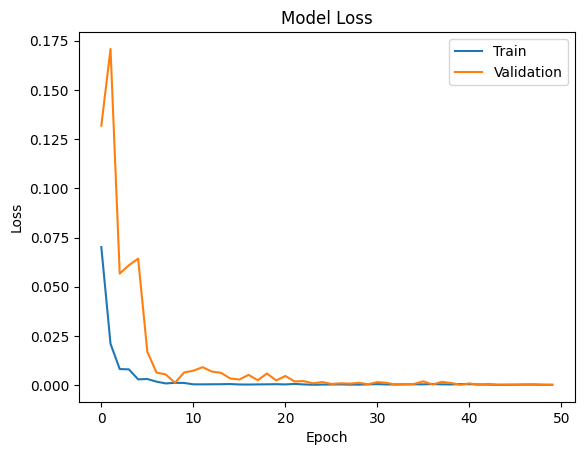

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics
prediction = model.predict(train_x[-n_month_for_prediction:])
mse = mean_squared_error(train_y[-n_month_for_prediction:], prediction)
fmape = np.mean(np.abs((mse) / prediction)) * 100
mape = f"{(fmape*100):.2f}%"
mae = np.mean(np.abs((mse) / prediction))

print("MSE:", mse)
print("MAPE:", mape)
print("MAE:", mae)

1/1 [==============================] - 2s 2s/step
MSE: 0.00022627554323967987
MAPE: 3.18%
MAE: 0.00031814037


In [ ]:
prediction_copies = np.repeat(prediction, data_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

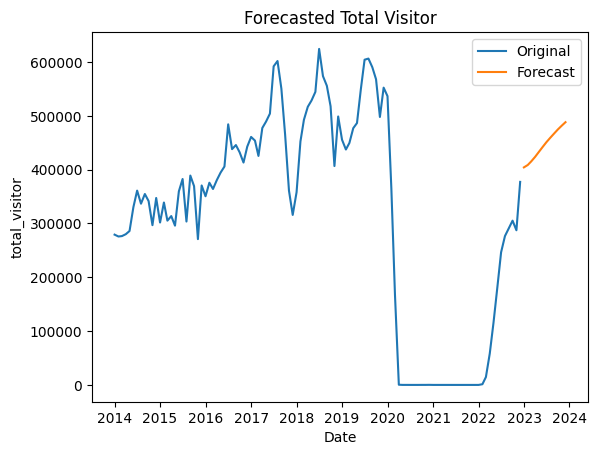

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │       404219 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │       408682 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │       415384 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │       423783 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │       432933 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │       442297 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │       451139 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │       459354 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │       467259 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │       474784 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │       481789 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates_1 = []

for time_i in predict_period_month:
    forecast_dates_1.append(time_i.date())

df_forecast = pd.DataFrame({'Date': forecast_dates_1, 'Total Visitor': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='Total Visitor', label='Forecast')

plt.xlabel('Date')
plt.ylabel('total_visitor')
plt.title('Forecasted Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_1, y_pred_future))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table)

# Scenario 2 - 70% Train - 30 % Test

In [ ]:
# Define sequence length and features
sequence_length2 = 12  # Number of time steps in each sequence
num_features2 = len(data_for_training.columns)

# Create sequences and corresponding labels
sequences2 = []
labels2 = []
for i in range(len(scaled_data) - sequence_length2):
    seq = scaled_data[i:i+sequence_length2]
    label = scaled_data[i+sequence_length2][1]  # '_tempm' column index
    sequences2.append(seq)
    labels2.append(label)

# Convert to numpy arrays
sequences2 = np.array(sequences2)
labels2 = np.array(labels2)

# Split into train and test sets
train_size2 = int(0.7 * len(sequences2))
train_x2, test_x2 = sequences2[:train_size2], sequences2[train_size2:]
train_y2, test_y2 = labels2[:train_size2], labels2[train_size2:]

print("Train X2 shape:", train_x2.shape)
print("Train Y2 shape:", train_y2.shape)
print("Test X2 shape:", test_x2.shape)
print("Test Y2 shape:", test_y2.shape)

Train X2 shape: (67, 12, 2)
Train Y2 shape: (67,)
Test X2 shape: (29, 12, 2)
Test Y2 shape: (29,)


In [ ]:
# Create the GRU model
model2 = Sequential()

# Add GRU layers with dropout
model2.add(GRU(units=256, input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))

model2.add(GRU(units=128, return_sequences=True))
model2.add(Dropout(0.2))

model2.add(GRU(units=64, return_sequences=False))

# Add a dense output layer
model2.add(Dense(units=1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 12, 256)           199680    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0         
                                                                 
 gru_4 (GRU)                 (None, 12, 128)           148224    
                                                                 
 dropout_3 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385217 (1.47 MB)
Trainable params: 38521

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history2 = model2.fit(
    train_x2, train_y2,
    epochs=50,
    batch_size=12,
    validation_split=0.3,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/50
4/4 [==============================] - 11s 1s/step - loss: 0.0412 - val_loss: 0.0311
Epoch 2/50
4/4 [==============================] - 0s 135ms/step - loss: 0.0093 - val_loss: 0.0890
Epoch 3/50
4/4 [==============================] - 0s 91ms/step - loss: 0.0073 - val_loss: 0.0135
Epoch 4/50
4/4 [==============================] - 1s 144ms/step - loss: 0.0057 - val_loss: 0.0201
Epoch 5/50
4/4 [==============================] - 1s 144ms/step - loss: 0.0025 - val_loss: 0.0378
Epoch 6/50
4/4 [==============================] - 0s 112ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 7/50
4/4 [==============================] - 1s 143ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 8/50
4/4 [==============================] - 1s 155ms/step - loss: 6.1408e-04 - val_loss: 0.0055
Epoch 9/50
4/4 [==============================] - 0s 132ms/step - loss: 6.7042e-04 - val_loss: 0.0013
Epoch 10/50
4/4 [==============================] - 1s 145ms/step - loss: 4.0988e-04 - val_loss: 0.0012
Epoch 11/5

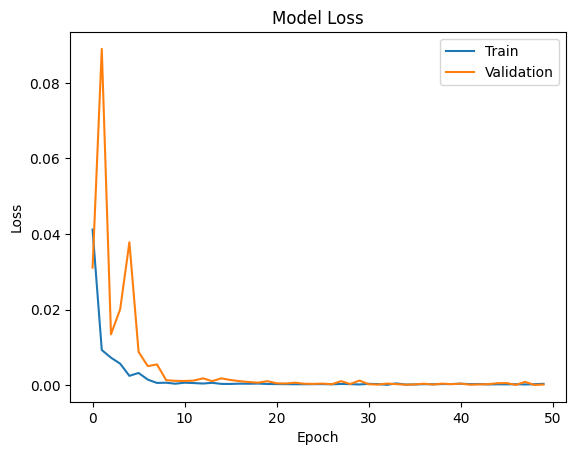

In [ ]:
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict for 12 month afterwards
n_past2 = 1
n_month_for_prediction2 = 12
predict_period_month2 = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction2, freq='M').tolist()
print(predict_period_month2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics
prediction2 = model2.predict(train_x2[-n_month_for_prediction2:])
mse2 = mean_squared_error(train_y2[-n_month_for_prediction2:], prediction2)
fmape2 = np.mean(np.abs((mse2) / prediction2)) * 100
mape2 = f"{(fmape2*100):.2f}%"
mae2 = np.mean(np.abs((mse2) / prediction2))

print("MSE:", mse2)
print("MAPE:", mape2)
print("MAE:", mae2)

1/1 [==============================] - 1s 1s/step
MSE: 0.00026560518684805805
MAPE: 4.27%
MAE: 0.0004270319


In [ ]:
prediction_copies2 = np.repeat(prediction2, data_for_training.shape[1], axis=-1)
y_pred_future2 = scaler.inverse_transform(prediction_copies2)[:,0]

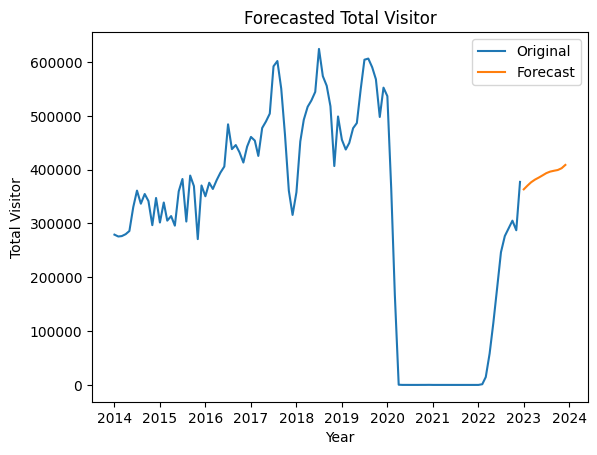

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │       363440 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │       370616 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │       376568 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │       381505 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │       385220 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │       389379 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │       393537 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │       396395 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │       397995 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │       399358 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │       402664 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates_2 = []

for time_i in predict_period_month2:
    forecast_dates_2.append(time_i.date())

df_forecast_2 = pd.DataFrame({'Date': forecast_dates_2, 'Total Visitor': y_pred_future2})
df_forecast_2['Date'] = pd.to_datetime(df_forecast_2['Date'])

sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast_2, x='Date', y='Total Visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_2 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data2 = list(zip(forecast_dates_2, y_pred_future2))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table2 = tabulate(data2, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table2)

# Scenario 3 - 60% Train - 40 % Test

In [ ]:
# Define sequence length and features
sequence_length3 = 12  # Number of time steps in each sequence
num_features3 = len(data_for_training.columns)

# Create sequences and corresponding labels
sequences3 = []
labels3 = []
for i in range(len(scaled_data) - sequence_length3):
    seq = scaled_data[i:i+sequence_length3]
    label = scaled_data[i+sequence_length3][1]  # '_tempm' column index
    sequences3.append(seq)
    labels3.append(label)

# Convert to numpy arrays
sequences3 = np.array(sequences3)
labels3 = np.array(labels3)

# Split into train and test sets
train_size3 = int(0.6 * len(sequences3))
train_x3, test_x3 = sequences3[:train_size3], sequences3[train_size3:]
train_y3, test_y3 = labels3[:train_size3], labels3[train_size3:]

print("Train X3 shape:", train_x3.shape)
print("Train Y3 shape:", train_y3.shape)
print("Test X3 shape:", test_x3.shape)
print("Test Y3 shape:", test_y3.shape)

Train X3 shape: (57, 12, 2)
Train Y3 shape: (57,)
Test X3 shape: (39, 12, 2)
Test Y3 shape: (39,)


In [ ]:
# Create the GRU model
model3 = Sequential()

# Add GRU layers with dropout
model3.add(GRU(units=256, input_shape=(train_x3.shape[1], train_x3.shape[2]), return_sequences=True))
model3.add(Dropout(0.2))

model3.add(GRU(units=128, return_sequences=True))
model3.add(Dropout(0.2))

model3.add(GRU(units=64, return_sequences=False))

# Add a dense output layer
model3.add(Dense(units=1))

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 12, 256)           199680    
                                                                 
 dropout_4 (Dropout)         (None, 12, 256)           0         
                                                                 
 gru_7 (GRU)                 (None, 12, 128)           148224    
                                                                 
 dropout_5 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385217 (1.47 MB)
Trainable params: 38521

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history3 = model3.fit(
    train_x3, train_y3,
    epochs=50,
    batch_size=12,
    validation_split=0.4,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/50
3/3 [==============================] - 8s 837ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 2/50
3/3 [==============================] - 0s 125ms/step - loss: 0.0043 - val_loss: 0.0632
Epoch 3/50
3/3 [==============================] - 0s 110ms/step - loss: 0.0043 - val_loss: 0.0153
Epoch 4/50
3/3 [==============================] - 0s 124ms/step - loss: 0.0036 - val_loss: 0.0100
Epoch 5/50
3/3 [==============================] - 0s 129ms/step - loss: 0.0021 - val_loss: 0.0320
Epoch 6/50
3/3 [==============================] - 0s 118ms/step - loss: 0.0033 - val_loss: 0.0296
Epoch 7/50
3/3 [==============================] - 0s 137ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 8/50
3/3 [==============================] - 0s 127ms/step - loss: 0.0021 - val_loss: 0.0068
Epoch 9/50
3/3 [==============================] - 0s 121ms/step - loss: 0.0012 - val_loss: 0.0169
Epoch 10/50
3/3 [==============================] - 0s 107ms/step - loss: 0.0012 - val_loss: 0.0083
Epoch 11/50
3/3 [==

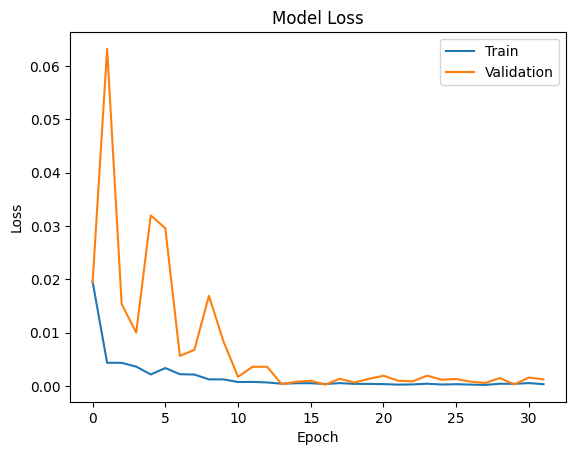

In [ ]:
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict for 12 month afterwards
n_past3 = 1
n_month_for_prediction3 = 12
predict_period_month3 = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction3, freq='M').tolist()
print(predict_period_month3)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics
prediction3 = model3.predict(train_x3[-n_month_for_prediction3:])
mse3 = mean_squared_error(train_y3[-n_month_for_prediction3:], prediction3)
fmape3 = np.mean(np.abs((mse3) / prediction3)) * 100
mape3 = f"{(fmape3*100):.2f}%"
mae3 = np.mean(np.abs((mse3) / prediction3))

print("MSE:", mse3)
print("MAPE:", mape3)
print("MAE:", mae3)

1/1 [==============================] - 1s 1s/step
MSE: 0.00025166180787939476
MAPE: 4.65%
MAE: 0.0004645706


In [ ]:
prediction_copies3 = np.repeat(prediction3, data_for_training.shape[1], axis=-1)
y_pred_future3 = scaler.inverse_transform(prediction_copies3)[:,0]

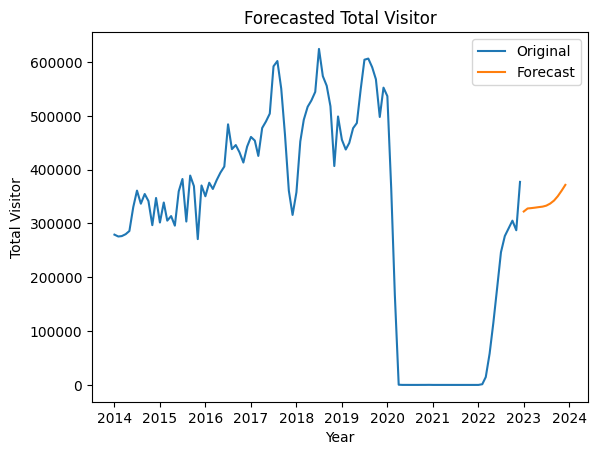

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │       322268 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │       327884 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │       328522 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │       329395 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │       330394 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │       331290 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │       333144 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │       336945 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │       342565 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │       350608 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │       360927 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates_3 = []

for time_i in predict_period_month3:
    forecast_dates_3.append(time_i.date())

df_forecast_3 = pd.DataFrame({'Date': forecast_dates_3, 'Total Visitor': y_pred_future3})
df_forecast_3['Date'] = pd.to_datetime(df_forecast_3['Date'])

sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast_3, x='Date', y='Total Visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_3 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data3 = list(zip(forecast_dates_3, y_pred_future3))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table3 = tabulate(data3, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table3)

# Conclusion

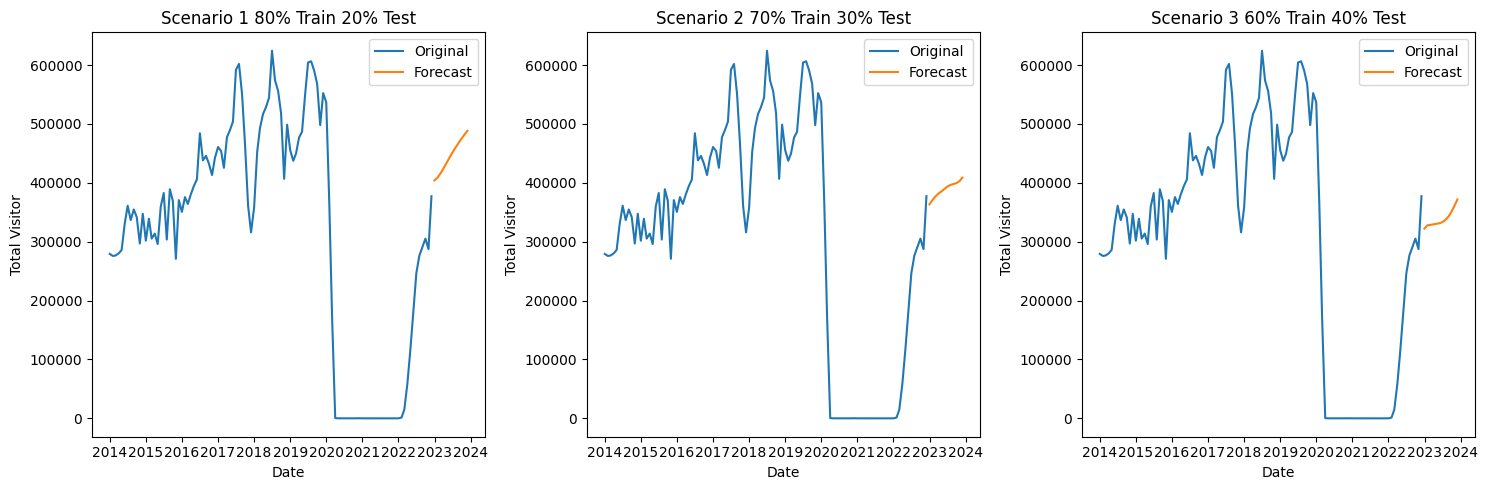

╒════════════╤═════════╤═════════════╤═════════════╤════════╕
│ Scenario   │ Model   │         MAE │         MSE │ MAPE   │
╞════════════╪═════════╪═════════════╪═════════════╪════════╡
│ Scenario 1 │ GRU     │ 0.00031814  │ 0.000226276 │ 3.18%  │
├────────────┼─────────┼─────────────┼─────────────┼────────┤
│ Scenario 2 │ GRU     │ 0.000427032 │ 0.000265605 │ 4.27%  │
├────────────┼─────────┼─────────────┼─────────────┼────────┤
│ Scenario 3 │ GRU     │ 0.000464571 │ 0.000251662 │ 4.65%  │
╘════════════╧═════════╧═════════════╧═════════════╧════════╛


In [ ]:
plt.figure(figsize=(15, 5))

# Scenario 1
plt.subplot(1, 3, 1)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='Total Visitor', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 1 80% Train 20% Test')
plt.legend()

# Scenario 2
plt.subplot(1, 3, 2)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast_2, x='Date', y='Total Visitor', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 2 70% Train 30% Test')
plt.legend()

# Scenario 3
plt.subplot(1, 3, 3)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast_3 , x='Date', y='Total Visitor', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 3 60% Train 40% Test')
plt.legend()

plt.tight_layout()
plt.show()

# Define the data for each scenario
scenario_data = [
    {
        'Scenario': 'Scenario 1',
        'Model': 'GRU',
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape
    },
    {
        'Scenario': 'Scenario 2',
        'Model': 'GRU',
        'MAE': mae2,
        'MSE': mse2,
        'MAPE': mape2
    },
    {
        'Scenario': 'Scenario 3',
        'Model': 'GRU',
        'MAE': mae3,
        'MSE': mse3,
        'MAPE': mape3
    }
]

# Create a DataFrame from the scenario data
df = pd.DataFrame(scenario_data)

# Convert DataFrame to a list of rows
rows = df.values.tolist()

# Create a list of headers
headers = df.columns.tolist()

# Generate the table
table4 = tabulate(rows, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table4)